**Outline**

1. Load raw data
2. Prepare unpaired image translation dataset
3. Write network code
4. Write objective function, Write training and evaluation loops
5. Train network
6. Evaluate network
7. Load new dataset
8. Prepare unaired image translation dataset
9. Use network, objective function, training and evaluation loop from previous section. 
10. Train and evaluate

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils import data
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.current_device(), torch.cuda.device_count()

(0, 1)

**Load raw data**

In [3]:
batch_size = 25

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                    ])),
    batch_size=batch_size, shuffle=True)

train_loader, test_loader

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!



/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


(<torch.utils.data.dataloader.DataLoader at 0x7fcb03a44be0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcaa6233d30>)

**Prepare unpaired image translation dataset**

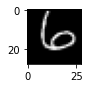

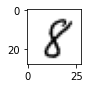

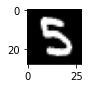

In [4]:
def tensor2image(x):
  return x.detach().numpy().transpose(0, 2, 3, 1)

def image2tensor(x):
  return torch.tensor(x.transpose(0, 3, 1, 2))

def display_image(image):
  plt.figure(figsize=(1,1))
  plt.imshow(image[:,:,0], cmap = 'gray')
  plt.show()



X = np.array([ tensor2image(image_batch) for image_batch, _ in train_loader])
X = X.reshape((X.shape[0] * X.shape[1], X.shape[2], X.shape[3], X.shape[4]))

Y = np.array(X) * -1
np.random.shuffle(Y)

display_image(X[0])
display_image(Y[0])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
unsupervised_train_loader = data.DataLoader(data.TensorDataset(image2tensor(X_train), image2tensor(Y_train)), batch_size=1)
unsupervised_test_loader = data.DataLoader(data.TensorDataset(image2tensor(X_test), image2tensor(Y_test)), batch_size=1)
unsupervised_train_loader, unsupervised_test_loader

x, y = next(iter(unsupervised_train_loader))
c = tensor2image(x.cpu()[0:1])
display_image(c[0])

**Network code**

In [5]:
class Generator(nn.Module):
  def __init__(self):
    '''
    Network is a map from noise vector to image
    (Batch, 128) -> (Batch, 1, w, h)
    '''
    super(Generator, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 2)
    self.conv2 = nn.Conv2d(32, 32, 3, 2)
    self.fc1 = nn.Linear(32 * 6 * 6, 128)
    
    self.fc2 = nn.Linear(128, 128)
    self.conv1T = nn.ConvTranspose2d(32, 32, 3, 2)
    self.conv2T = nn.ConvTranspose2d(64, 32, 3, 2)
    self.conv3T = nn.ConvTranspose2d(64, 32, 3, 2)
    self.conv4T = nn.ConvTranspose2d(32, 1, 3, 1, padding = 1)

    

  def forward(self, x):
    # DOWN 
    x1 = self.conv1(x) # (Batch_size, 32, 13, 13)
    x1 = nn.LeakyReLU(0.2)(x1) # (Batch_size, 32, 13, 13)
    x2 = self.conv2(x1) # (Batch_size, 32, 6, 6)
    x2 = nn.LeakyReLU(0.2)(x2) # (Batch_size, 32, 6, 6)
    x3 = self.fc1(x2.reshape((-1, 32 * 6 * 6))) # (Batch_size, 128)
    x3 = nn.LeakyReLU(0.2)(x3) # (Batch_size, 128)

    # UP
    x4 = self.fc2(x3) # (Batch_size, 128)
    x4 = nn.LeakyReLU(0.1)(x4) # (Batch_size, 128)
    x4 = x4.view((-1, 32, 2, 2)) # (Batch_size, 32, 2, 2)
    
    
    x5 = self.conv1T(x4, output_size = (x.shape[0], 32, 6, 6)) # (Batch_size, 32, 6 , 6)
    x5 = nn.BatchNorm2d(32)(x5) # (Batch_size, 32 * 6 * 6)
    x5 = nn.LeakyReLU(0.1)(x5) # (Batch_size, 32, 6, 6)

    x5_stack = torch.cat((x5, x2), dim = 1) ## (Batch_size, 64, 6, 6)
    x6 = self.conv2T(x5_stack, output_size = (x.shape[0], 32 , 13, 13)) # (Batch_size, 32, 13, 13)
    x6 = nn.BatchNorm2d(32)(x6) # (Batch_size, 32 * 13 * 13)
    x6 = nn.LeakyReLU(0.1)(x6) # (Batch_size, 32, 13, 13)

    x6_stack = torch.cat((x6, x1), dim = 1) #(Batch_size, 64, 13, 13)
    x7 = self.conv3T(x6_stack, output_size = (x.shape[0], 1 , 28, 28)) # (Batch_size, 1, 28, 28)
    x7 = nn.LeakyReLU(0.1)(x7)
    x8 = self.conv4T(x7, output_size = (x.shape[0], 1 , 28, 28)) # (Batch_size, 1, 28, 28)
  
    return nn.Tanh()(x8)

class Discriminator(nn.Module):
  def __init__(self):
    '''
    Network is a map from an image to (0, 1)
    (Batch, 1, w, h) -> (Batch, )
    '''
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 2)
    self.conv2 = nn.Conv2d(32, 32, 3, 2)
    self.fc1 = nn.Linear(32 * 6 * 6, 128)
    self.output = nn.Linear(128, 1)

  def forward(self, x):
    x = self.conv1(x) # (Batch_size, 32, 13, 13)
    x = nn.LeakyReLU(0.2)(x) # (Batch_size, 32, 13, 13)
    x = self.conv2(x) # (Batch_size, 32, 6, 6)
    x = nn.LeakyReLU(0.2)(x) # (Batch_size, 32, 6, 6)
    x = x.reshape((-1, 32 * 6 * 6)) # (Batch_size, 32 * 6 * 6)
    x = self.fc1(x) # (Batch_size, 128)
    x = nn.LeakyReLU(0.2)(x) # (Batch_size, 128)
    x = self.output(x)
    return nn.Sigmoid()(x)


generator = Generator()
discriminator = Discriminator()
generated = generator(torch.randn(10, 1, 28, 28))

predictions = discriminator(generated)
next(generator.parameters()).is_cuda

True

**Psuedocode**

 Networks D_x, D_y, F, G

```
G maps from X to Y
F maps from Y to X

D_x maps from (b, w_x, s_x, 3) -> {0, 1}
D_y maps from (b, w_y, s_y, 3) -> {0, 1}

G maps from (b, w_x, s_x, 3) -> (b, w_y, s_y, 3)
F maps from (b, w_y, s_y, 3) -> (b, w_x, s_x, 3)

CE(y, y_pred) = -sum(ylog(y_pred))

for batch X, Y
  D_y_loss = CE(ones, D_y(y)) + CE(zeros, D_y(G(x)))
  D_x_loss = CE(ones, D_x(x)) + CE(zeros, D_x(G(y)))
  cyclical_loss = |F(G(x)) - x | + |G(F(y)) - y |
  G_loss = CE(ones, D_y(G(x))) + cyclical_loss
  F_loss = CE(ones, D_x(G(y))) + cyclical_loss
  G_loss += cyclical_loss
  F_loss += cyclical_loss

  Compute gradients
  Update G, F, D_x, D_y weights

```






**Write Objective function, training loop**

In [6]:
G = Generator()
F = Generator()
D_X = Discriminator()
D_Y = Discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = 1e-4)
F_optimizer = optim.Adam(F.parameters(), lr = 1e-4)
D_X_optimizer = optim.Adam(D_X.parameters(), lr = 1e-4)
D_Y_optimizer = optim.Adam(D_Y.parameters(), lr = 1e-4)


def train(G, F, D_X, D_Y, train_loader):
  G_losses = []
  F_losses = []
  D_Y_losses = []
  D_X_losses = []
  for i, (X, Y) in enumerate(train_loader):
    X = X.cuda()
    Y = Y.cuda()
    for p in D_X.parameters(): p.requires_grad = True
    for p in D_Y.parameters(): p.requires_grad = True

    # train D_X, D_Y
    D_X.zero_grad()
    D_Y.zero_grad()

    D_Y_loss = nn.BCELoss()(D_Y(Y), torch.ones((X.shape[0], 1))) + nn.BCELoss()(D_Y(G(X)), torch.zeros((X.shape[0], 1)))
    D_X_loss = nn.BCELoss()(D_X(X), torch.ones((X.shape[0], 1))) + nn.BCELoss()(D_X(F(Y)), torch.zeros((X.shape[0], 1)))
    D_Y_loss.backward(retain_graph=True)
    D_X_loss.backward(retain_graph=True)
    D_X_optimizer.step()
    D_Y_optimizer.step()

    # train G, F
    F.zero_grad()
    G.zero_grad()
    for p in D_X.parameters(): p.requires_grad = False
    for p in D_Y.parameters(): p.requires_grad = False

    cyclical_loss = torch.mean(torch.abs(F(G(X)) - X)) + torch.mean(torch.abs(G(F(Y)) - Y))
    
    G_loss = nn.BCELoss()(D_Y(G(X)), torch.ones((X.shape[0], 1))) + 2 * cyclical_loss
    F_loss = nn.BCELoss()(D_X(F(Y)), torch.ones((X.shape[0], 1))) + 2 * cyclical_loss

    G_loss.backward(retain_graph = True)
    F_loss.backward()
    G_optimizer.step()
    F_optimizer.step()
    
    G_losses.append(G_loss.mean().item())
    F_losses.append(F_loss.mean().item())
    D_X_losses.append(D_X_loss.mean().item())
    D_Y_losses.append(D_Y_loss.mean().item())

    if i % 100 == 0:
      print(D_X_loss.mean().item(), D_Y_loss.mean().item(), G_loss.mean().item(), F_loss.mean().item(), cyclical_loss.item())
      #print(X.is_cuda, G(X).is_cuda, D_Y(Y).is_cuda)

for epoch in range(2):
  print(epoch)
  train(G, F, D_X, D_Y, unsupervised_train_loader)

0
1.3894200325012207 1.4103442430496216 3.9751343727111816 3.960324287414551 1.6134769916534424
1.1699737310409546 1.474034070968628 2.2101104259490967 2.1441547870635986 0.4916059076786041
1.4534111022949219 1.4789091348648071 1.040050745010376 1.1699628829956055 0.24235203862190247
1.7031245231628418 1.3279242515563965 1.010241985321045 0.8418810963630676 0.16528400778770447
1.4462578296661377 1.3732353448867798 0.9319513440132141 0.8825123310089111 0.10926544666290283
1.3892202377319336 1.3224260807037354 0.8316453695297241 0.8433784246444702 0.0668485164642334
1.3846904039382935 1.362098217010498 0.9346747398376465 0.906865656375885 0.09927389025688171
1.395173192024231 1.3874342441558838 0.8691070079803467 0.8155261278152466 0.06843997538089752
1.3892731666564941 1.3964706659317017 0.8882049322128296 0.8241544365882874 0.07896772027015686
1.4003584384918213 1.3975613117218018 0.8789058923721313 0.8028964996337891 0.07597886025905609
1.4048047065734863 1.4224662780761719 0.79729998

## Evaluate network
**Display and check quality of generated images**

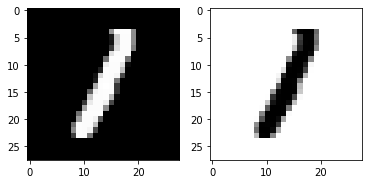

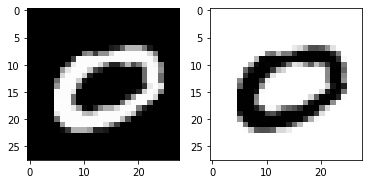

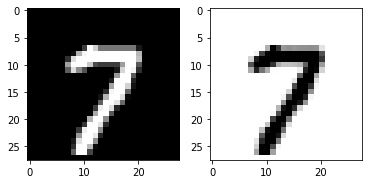

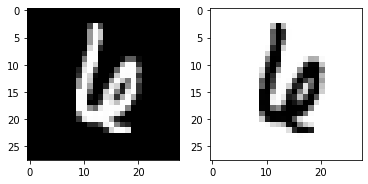

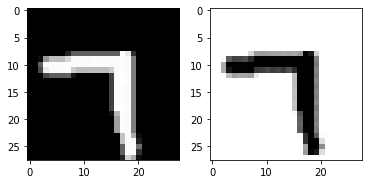

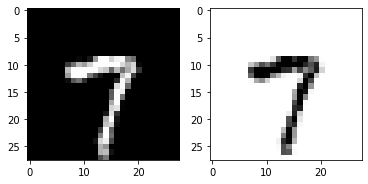

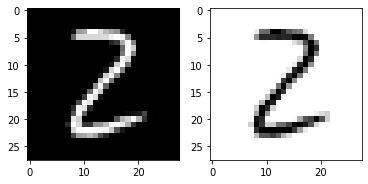

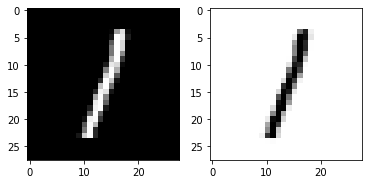

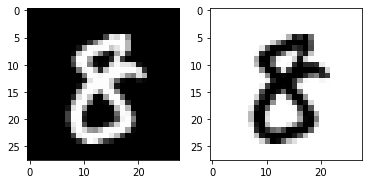

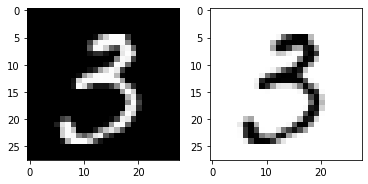

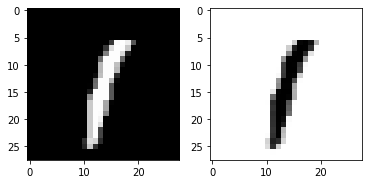

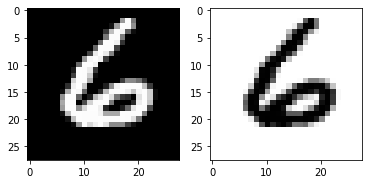

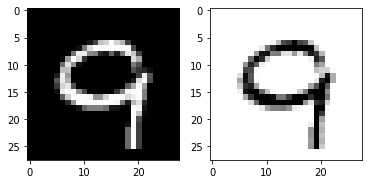

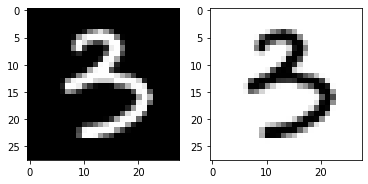

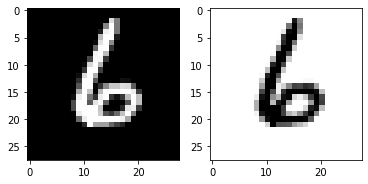

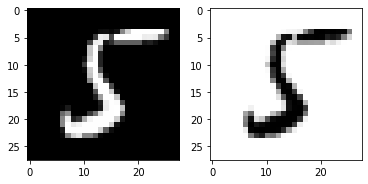

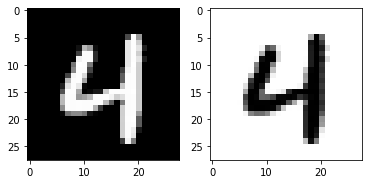

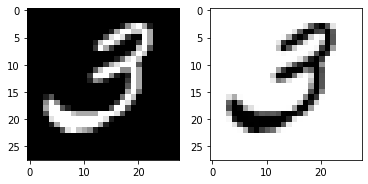

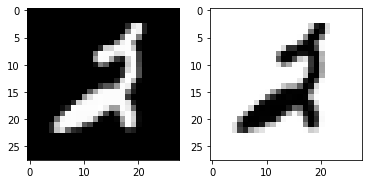

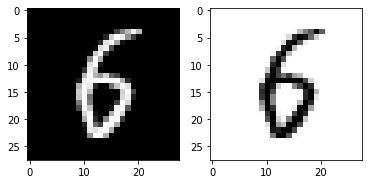

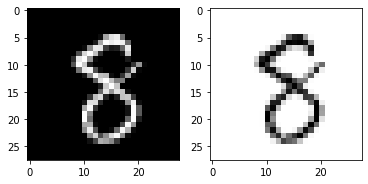

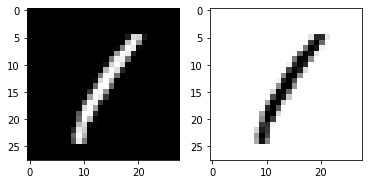

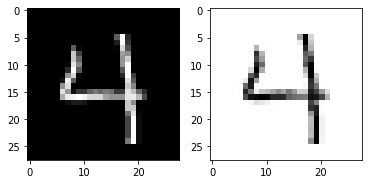

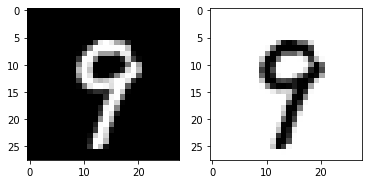

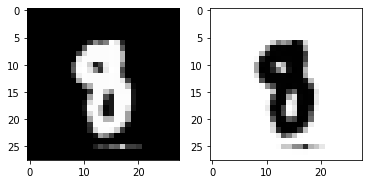

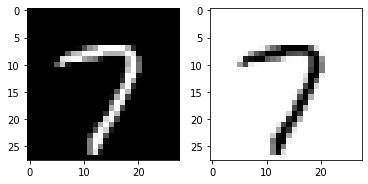

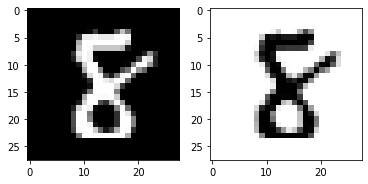

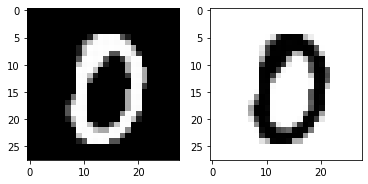

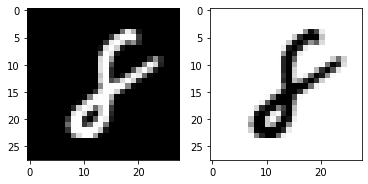

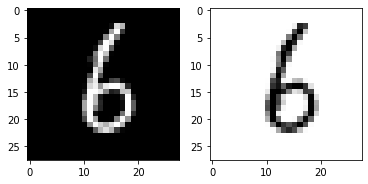

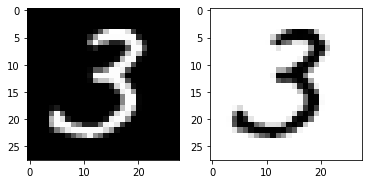

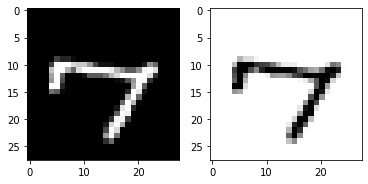

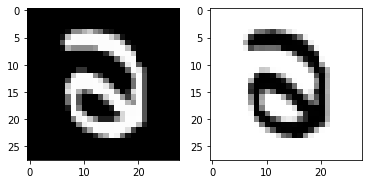

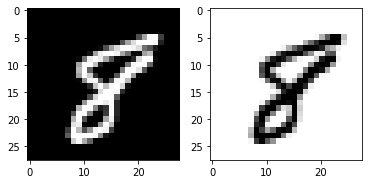

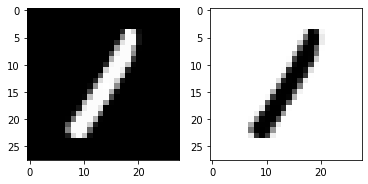

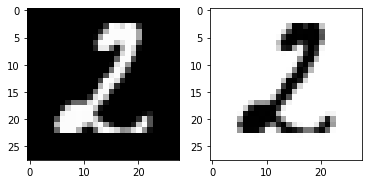

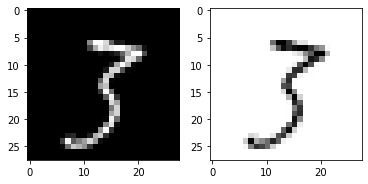

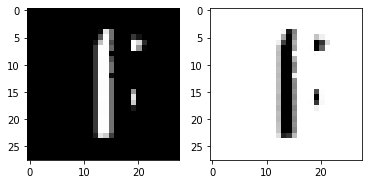

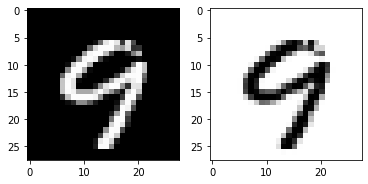

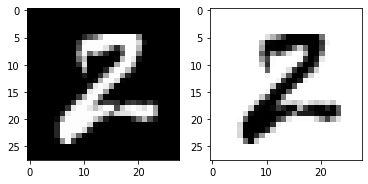

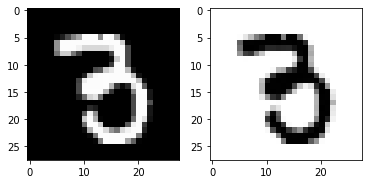

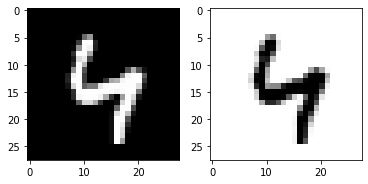

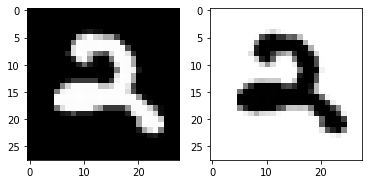

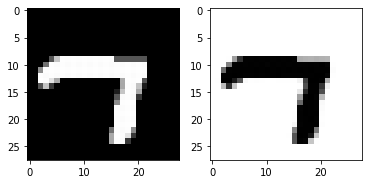

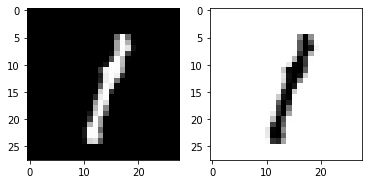

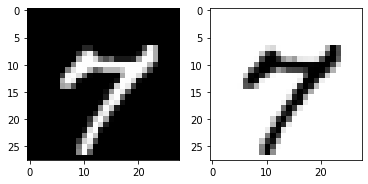

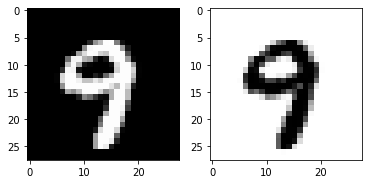

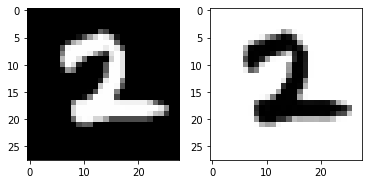

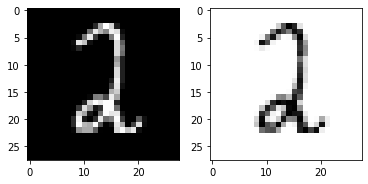

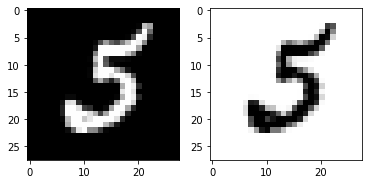

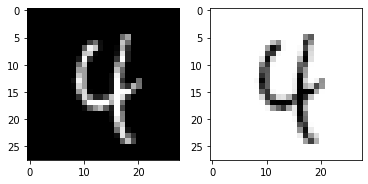

In [7]:
def display_image_side(image1, image2):
  plt.subplot(1, 2, 1)
  plt.imshow(image1[:,:,0], cmap = 'gray')
  
  plt.subplot(1, 2, 2)
  plt.imshow(image2[:,:,0], cmap = 'gray')
  plt.show()



for j, (inputs, _)  in enumerate(iter(unsupervised_test_loader)):
  if j > 50:
    break
  predictions = G(inputs).cpu()
  inputs_numpy = tensor2image(inputs.cpu())
  predictions_numpy = tensor2image(predictions.cpu())
  for i, (inpt, prediction) in enumerate(zip(inputs_numpy, predictions_numpy)):
    display_image_side(inpt, prediction)